# Bitcoin Confluence Strategy (Self-contained)
Loads cached Binance OHLCV (1d, 1h, 4h) and runs the confluence backtest entirely within this notebook.


In [11]:
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

warnings.filterwarnings('ignore')

START  = '2017-01-01'
END    = None
SPLIT  = '2021-01-01'

CTX    = 250
VA_PCT = 0.70

FEE    = 0.0005
SLIP   = 0.0005
COST   = FEE + SLIP

SWING_WIN   = 60
ATR_WIN     = 14
ENTRY_SCORE = 2
ATR_STOP_MULT = 1.5

BASE_DIR = Path.cwd()
TIMEFRAME_DIRS = {
    '1d': BASE_DIR / 'data',
    '1h': BASE_DIR / 'data_1h',
    '4h': BASE_DIR / 'data_4h',
}


In [12]:
def fetch_binance_data(symbols: list[str], timeframe: str = '1d') -> pd.DataFrame:
    tf_dir = TIMEFRAME_DIRS.get(timeframe)
    if tf_dir is None:
        raise ValueError(f"Unsupported timeframe '{timeframe}'.")
    frames: list[pd.DataFrame] = []
    for sym in symbols:
        csv_name = sym.replace('/', '') + '.csv'
        path = tf_dir / csv_name
        if not path.exists():
            raise FileNotFoundError(f"Cached data not found for {sym}. Expected file: {path}")
        df = pd.read_csv(path, parse_dates=['open_time'])
        df = df.rename(columns=str.lower)
        df.set_index('open_time', inplace=True)
        if getattr(df.index, 'tz', None) is not None:
            df.index = df.index.tz_convert('UTC').tz_localize(None)
        df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
        df.columns = pd.MultiIndex.from_product([[sym], df.columns])
        frames.append(df)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, axis=1).sort_index()

def pick_btc_symbol(exframe: pd.DataFrame) -> str:
    candidates = ['BTC/USDT', 'BTC/BUSD', 'BTC/USDC', 'BTC/FDUSD']
    for c in candidates:
        if (c, 'close') in exframe.columns:
            return c
    symbols = list({c[0] for c in exframe.columns})
    for s in symbols:
        if s.startswith('BTC/'):
            return s
    raise RuntimeError('No BTC symbols found in cached data.')


In [13]:
def rolling_atr(df: pd.DataFrame, win: int = ATR_WIN) -> pd.Series:
    high, low, close = df['high'], df['low'], df['close']
    tr = pd.concat([(high - low), (high - close.shift()).abs(), (low - close.shift()).abs()], axis=1).max(axis=1)
    return tr.rolling(win, min_periods=1).mean()

def volume_profile(ctx_close: pd.Series, ctx_vol: pd.Series, bins: int = CTX, va_pct: float = VA_PCT):
    lo, hi = ctx_close.min(), ctx_close.max()
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        centers = np.array([float(lo)])
        hist = np.array([float(ctx_vol.sum())])
        poc_px = float(lo)
        return poc_px, np.nan, np.nan, centers, hist
    edges = np.linspace(lo, hi, bins + 1)
    hist, edges = np.histogram(ctx_close.values, bins=edges, weights=ctx_vol.values)
    centers = (edges[:-1] + edges[1:]) / 2.0
    if hist.sum() <= 0:
        return float(centers[0]), np.nan, np.nan, centers, hist
    poc_px = float(centers[hist.argmax()])
    idx = int(hist.argmax())
    L = R = idx
    cum = hist[idx]
    total = hist.sum()
    while cum < va_pct * total and (L > 0 or R < len(hist) - 1):
        left = hist[L - 1] if L > 0 else -np.inf
        right = hist[R + 1] if R < len(hist) - 1 else -np.inf
        if right >= left:
            R += 1; cum += hist[R]
        else:
            L -= 1; cum += hist[L]
    VAL = float(centers[L])
    VAH = float(centers[R])
    return poc_px, VAL, VAH, centers, hist

def detect_npocs(poc: pd.Series, high: pd.Series, low: pd.Series, ref_close: pd.Series):
    idx = poc.index
    open_levels: list[float] = []
    npoc_above = np.full(len(idx), np.nan, dtype=float)
    npoc_below = np.full(len(idx), np.nan, dtype=float)
    prev_p = np.nan
    for i in range(len(idx)):
        lo = float(low.iloc[i]); hi = float(high.iloc[i]); c = float(ref_close.iloc[i])
        if open_levels:
            open_levels = [lvl for lvl in open_levels if not (lo <= lvl <= hi)]
        if np.isfinite(prev_p):
            open_levels.append(float(prev_p))
        if open_levels:
            above = [lvl for lvl in open_levels if lvl > c]
            below = [lvl for lvl in open_levels if lvl < c]
            npoc_above[i] = min(above) if above else np.nan
            npoc_below[i] = max(below) if below else np.nan
        prev_p = float(poc.iloc[i]) if np.isfinite(poc.iloc[i]) else np.nan
    return pd.Series(npoc_above, index=idx, name='npoc_above'), pd.Series(npoc_below, index=idx, name='npoc_below')

def last_swings(df: pd.DataFrame, win: int = SWING_WIN) -> tuple[int, int]:
    h = df['high'].values; l = df['low'].values
    highs = argrelextrema(h, np.greater_equal, order=win)[0]
    lows  = argrelextrema(l, np.less_equal,   order=win)[0]
    hi_idx = int(highs[-1]) if len(highs) else int(np.argmax(h))
    lo_idx = int(lows[-1])  if len(lows)  else int(np.argmin(l))
    return lo_idx, hi_idx

def anchored_vwap(close: pd.Series, vol: pd.Series, anchor_idx: int) -> pd.Series:
    pv = (close * vol).copy()
    v  = vol.copy()
    pv.iloc[:anchor_idx] = 0.0
    v.iloc[:anchor_idx] = 0.0
    vw = pv.cumsum() / v.cumsum()
    vw.iloc[:anchor_idx] = np.nan
    return vw

def golden_pocket_from_swing(lo_px: float, hi_px: float, uptrend: bool):
    hi, lo = hi_px, lo_px
    span = hi - lo
    if uptrend:
        gp_low  = hi - 0.65 * span
        gp_high = hi - 0.618 * span
    else:
        gp_low  = lo + 0.618 * span
        gp_high = lo + 0.65  * span
    return float(min(gp_low, gp_high)), float(max(gp_low, gp_high))


In [14]:
def build_btc_frame(timeframe: str = '1d') -> pd.DataFrame:
    preferred = ['BTC/USDT', 'BTC/BUSD', 'BTC/USDC', 'BTC/FDUSD']
    tf_dir = TIMEFRAME_DIRS.get(timeframe)
    if tf_dir is None:
        raise ValueError(f"Unsupported timeframe '{timeframe}'.")
    available = [s for s in preferred if (tf_dir / (s.replace('/', '') + '.csv')).exists()]
    if not available:
        raise RuntimeError(f"No cached Binance data found for BTC in {tf_dir}.")
    binance = fetch_binance_data(available, timeframe=timeframe)
    if binance.empty:
        raise RuntimeError('Cached Binance data returned empty frame.')
    sym = pick_btc_symbol(binance)
    df = binance[sym].copy()
    df = df.loc[df.index >= pd.Timestamp(START)]
    if END:
        df = df.loc[df.index <= pd.Timestamp(END)]
    df = df.rename(columns=str)
    df = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    df['atr'] = rolling_atr(df, ATR_WIN)
    poc, val, vah = [], [], []
    for i in range(len(df)):
        j0 = max(0, i - CTX + 1)
        ctx = df.iloc[j0:i+1]
        p_, vL_, vH_, _, _ = volume_profile(ctx['close'], ctx['volume'], bins=CTX, va_pct=VA_PCT)
        poc.append(p_); val.append(vL_); vah.append(vH_)
    df['poc'], df['val'], df['vah'] = poc, val, vah
    npoc_up, npoc_dn = detect_npocs(df['poc'], df['high'], df['low'], df['close'])
    df['npoc_above'], df['npoc_below'] = npoc_up, npoc_dn
    lo_i, hi_i = last_swings(df, SWING_WIN)
    df['avwap_from_lo'] = anchored_vwap(df['close'], df['volume'], lo_i)
    df['avwap_from_hi'] = anchored_vwap(df['close'], df['volume'], hi_i)
    lo_px, hi_px = float(df.iloc[lo_i]['low']), float(df.iloc[hi_i]['high'])
    uptrend = hi_i > lo_i
    gp_low, gp_high = golden_pocket_from_swing(lo_px, hi_px, uptrend)
    df['gp_low'], df['gp_high'], df['swing_dir'] = gp_low, gp_high, (1 if uptrend else -1)
    d_prev = df.shift(1)
    df['y_high'], df['y_low'], df['y_open'] = d_prev['high'], d_prev['low'], d_prev['open']
    wk = df.resample('W-FRI').agg({'open':'first','high':'max','low':'min','close':'last'})
    for col in ['open','high','low','close']:
        df[f'w_{col}'] = wk[col].shift().reindex(df.index).ffill()
    mo = df.resample('M').agg({'open':'first','high':'max','low':'min','close':'last'})
    for col in ['open','high','low','close']:
        df[f'm_{col}'] = mo[col].shift().reindex(df.index).ffill()
    return df.dropna(subset=['atr'])

def confluence_signals(df: pd.DataFrame, tol: float = 0.003) -> pd.DataFrame:
    s = pd.DataFrame(index=df.index)
    s['touch_npoc_long']  = df['npoc_below'].notna() & (df['low'] <= df['npoc_below']*(1+tol)) & (df['close'] > df['npoc_below'])
    s['touch_npoc_short'] = df['npoc_above'].notna() & (df['high'] >= df['npoc_above']*(1-tol)) & (df['close'] < df['npoc_above'])
    s['avwap_support'] = df['avwap_from_lo'].notna() & (df['low'] <= df['avwap_from_lo']*(1+tol)) & (df['close'] > df['avwap_from_lo'])
    s['avwap_resist']  = df['avwap_from_hi'].notna() & (df['high'] >= df['avwap_from_hi']*(1-tol)) & (df['close'] < df['avwap_from_hi'])
    s['reenter_value_long']  = df['val'].notna() & (df['close'].shift(1) < df['val'].shift(1)) & (df['close'] > df['val'])
    s['reenter_value_short'] = df['vah'].notna() & (df['close'].shift(1) > df['vah'].shift(1)) & (df['close'] < df['vah'])
    gp_hit = df['gp_low'].notna() & df['gp_high'].notna() & (df['low'] <= df['gp_high']) & (df['high'] >= df['gp_low'])
    s['golden_long']  = gp_hit & (df['swing_dir']==1)  & (df['close'] > df['gp_low'])
    s['golden_short'] = gp_hit & (df['swing_dir']==-1) & (df['close'] < df['gp_high'])
    return s.fillna(False).astype(bool)


In [15]:
def backtest(df: pd.DataFrame, sigs: pd.DataFrame, return_details: bool = False):
    pos = 0
    entry_px = stop_px = target_px = None
    rets: list[float] = []
    pos_hist: list[int] = []
    entry_flags: list[int] = []
    exit_flags: list[int] = []
    entry_prices: list[float] = []
    exit_prices: list[float] = []
    for i in range(1, len(df)):
        y, t = df.iloc[i - 1], df.iloc[i]
        sy = sigs.iloc[i - 1]
        atr = y['atr']
        if pos != 0 and stop_px is not None and target_px is not None:
            hit_stop = (t['low'] <= stop_px) if pos > 0 else (t['high'] >= stop_px)
            hit_tgt = (t['high'] >= target_px) if pos > 0 else (t['low'] <= target_px)
            if hit_stop or hit_tgt:
                exit_px = stop_px if hit_stop else target_px
                pnl = (exit_px / entry_px - 1.0) * pos
                rets.append(pnl - COST)
                pos = 0
                entry_px = stop_px = target_px = None
                pos_hist.append(pos)
                entry_flags.append(0)
                exit_flags.append(1)
                entry_prices.append(float('nan'))
                exit_prices.append(float(exit_px))
                continue
        long_score = (
            int(sy['touch_npoc_long'])
            + int(sy['avwap_support'])
            + int(sy['reenter_value_long'])
            + int(sy['golden_long'])
        )
        short_score = (
            int(sy['touch_npoc_short'])
            + int(sy['avwap_resist'])
            + int(sy['reenter_value_short'])
            + int(sy['golden_short'])
        )
        if pos == 0:
            if long_score >= ENTRY_SCORE and np.isfinite(y['val']):
                pos = +1
                entry_px = float(t['open'])
                structural = []
                if np.isfinite(y['val']):
                    structural.append(float(y['val']))
                if np.isfinite(y['npoc_below']):
                    structural.append(float(y['npoc_below']))
                stop_px = min(structural + [entry_px - ATR_STOP_MULT * atr]) if structural else entry_px - ATR_STOP_MULT * atr
                t_candidates = []
                if np.isfinite(y['vah']):
                    t_candidates.append(float(y['vah']))
                target_px = max(t_candidates) if t_candidates else entry_px + 2 * atr
                rets.append(0.0)
                pos_hist.append(pos)
                entry_flags.append(1)
                exit_flags.append(0)
                entry_prices.append(float(entry_px))
                exit_prices.append(float('nan'))
                continue
            if short_score >= ENTRY_SCORE and np.isfinite(y['vah']):
                pos = -1
                entry_px = float(t['open'])
                structural = []
                if np.isfinite(y['vah']):
                    structural.append(float(y['vah']))
                if np.isfinite(y['npoc_above']):
                    structural.append(float(y['npoc_above']))
                stop_px = max(structural + [entry_px + ATR_STOP_MULT * atr]) if structural else entry_px + ATR_STOP_MULT * atr
                t_candidates = []
                if np.isfinite(y['val']):
                    t_candidates.append(float(y['val']))
                target_px = min(t_candidates) if t_candidates else entry_px - 2 * atr
                rets.append(0.0)
                pos_hist.append(pos)
                entry_flags.append(1)
                exit_flags.append(0)
                entry_prices.append(float(entry_px))
                exit_prices.append(float('nan'))
                continue
            rets.append(0.0)
            pos_hist.append(pos)
            entry_flags.append(0)
            exit_flags.append(0)
            entry_prices.append(float('nan'))
            exit_prices.append(float('nan'))
        else:
            day_ret = (t['close'] / y['close'] - 1.0) * pos
            rets.append(day_ret)
            pos_hist.append(pos)
            entry_flags.append(0)
            exit_flags.append(0)
            entry_prices.append(float('nan'))
            exit_prices.append(float('nan'))
    ret_series = pd.Series(rets, index=df.index[1:], name='ret')
    if not return_details:
        return ret_series
    detail = pd.DataFrame({
        'pos': pos_hist,
        'entry_flag': entry_flags,
        'exit_flag': exit_flags,
        'entry_price': entry_prices,
        'exit_price': exit_prices,
    }, index=df.index[1:])
    return ret_series, detail

def stats_ser(r: pd.Series) -> pd.Series:
    r = r.dropna()
    if r.empty:
        return pd.Series({"Total Return": np.nan, "CAGR": np.nan, "Sharpe": np.nan, "MaxDD": np.nan})
    ann = 252
    eq = (1 + r).cumprod()
    total = float(eq.iloc[-1] - 1)
    cagr  = float((1 + r).prod() ** (ann / len(r)) - 1)
    sharpe = float(np.sqrt(ann) * r.mean() / (r.std() + 1e-12))
    mdd   = float((eq / eq.cummax() - 1).min())
    return pd.Series({"Total Return": total, "CAGR": cagr, "Sharpe": sharpe, "MaxDD": mdd})


In [16]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

timeframes = ['1d', '1h', '4h']
frames = {}
returns_map = {}
details = {}
metrics_tables = {}

for tf in timeframes:
    df_tf = build_btc_frame(tf)
    sigs_tf = confluence_signals(df_tf)
    ret_tf, detail_tf = backtest(df_tf, sigs_tf, return_details=True)
    frames[tf] = df_tf
    returns_map[tf] = ret_tf
    equity_tf = (1 + ret_tf).cumprod()
    detail_tf = detail_tf.assign(
        equity=equity_tf.reindex(detail_tf.index),
        close=df_tf['close'].reindex(detail_tf.index),
        timeframe=tf,
    )
    details[tf] = detail_tf
    split_ts = pd.Timestamp(SPLIT)
    ins = ret_tf.loc[:split_ts - pd.Timedelta(days=1)]
    oos = ret_tf.loc[split_ts:]
    metrics_tables[tf] = pd.concat(
        {f'In-sample (< {SPLIT})': stats_ser(ins), f'Out-of-sample (>= {SPLIT})': stats_ser(oos)},
        axis=1,
    )
    median_step = df_tf.index.to_series().diff().dropna().median()
    print(f"{tf}: rows={len(df_tf):,}, median step={median_step}")

metrics_df = pd.concat(metrics_tables, axis=1)
metrics_df


1d: rows=3,000, median step=1 days 00:00:00
1h: rows=71,845, median step=0 days 01:00:00
4h: rows=17,978, median step=0 days 04:00:00


1d                                \
             In-sample (< 2021-01-01) Out-of-sample (>= 2021-01-01)   
Total Return                 1.359661                     -0.355925   
CAGR                         0.191968                     -0.060814   
Sharpe                       0.606178                     -0.553085   
MaxDD                       -0.560753                     -0.415226   

                                   1h                                \
             In-sample (< 2021-01-01) Out-of-sample (>= 2021-01-01)   
Total Return                13.094762                     -0.288828   
CAGR                         0.022898                     -0.002025   
Sharpe                       0.227682                      0.001939   
MaxDD                       -0.583843                     -0.694286   

                                   4h                                
             In-sample (< 2021-01-01) Out-of-sample (>= 2021-01-01)  
Total Return                 0.217595                     -0.788883  
CAGR                         0.006750                     -0.036311  
Sharpe                       0.123187                     -0.391631  
MaxDD                       -0.678978                     -0.802456

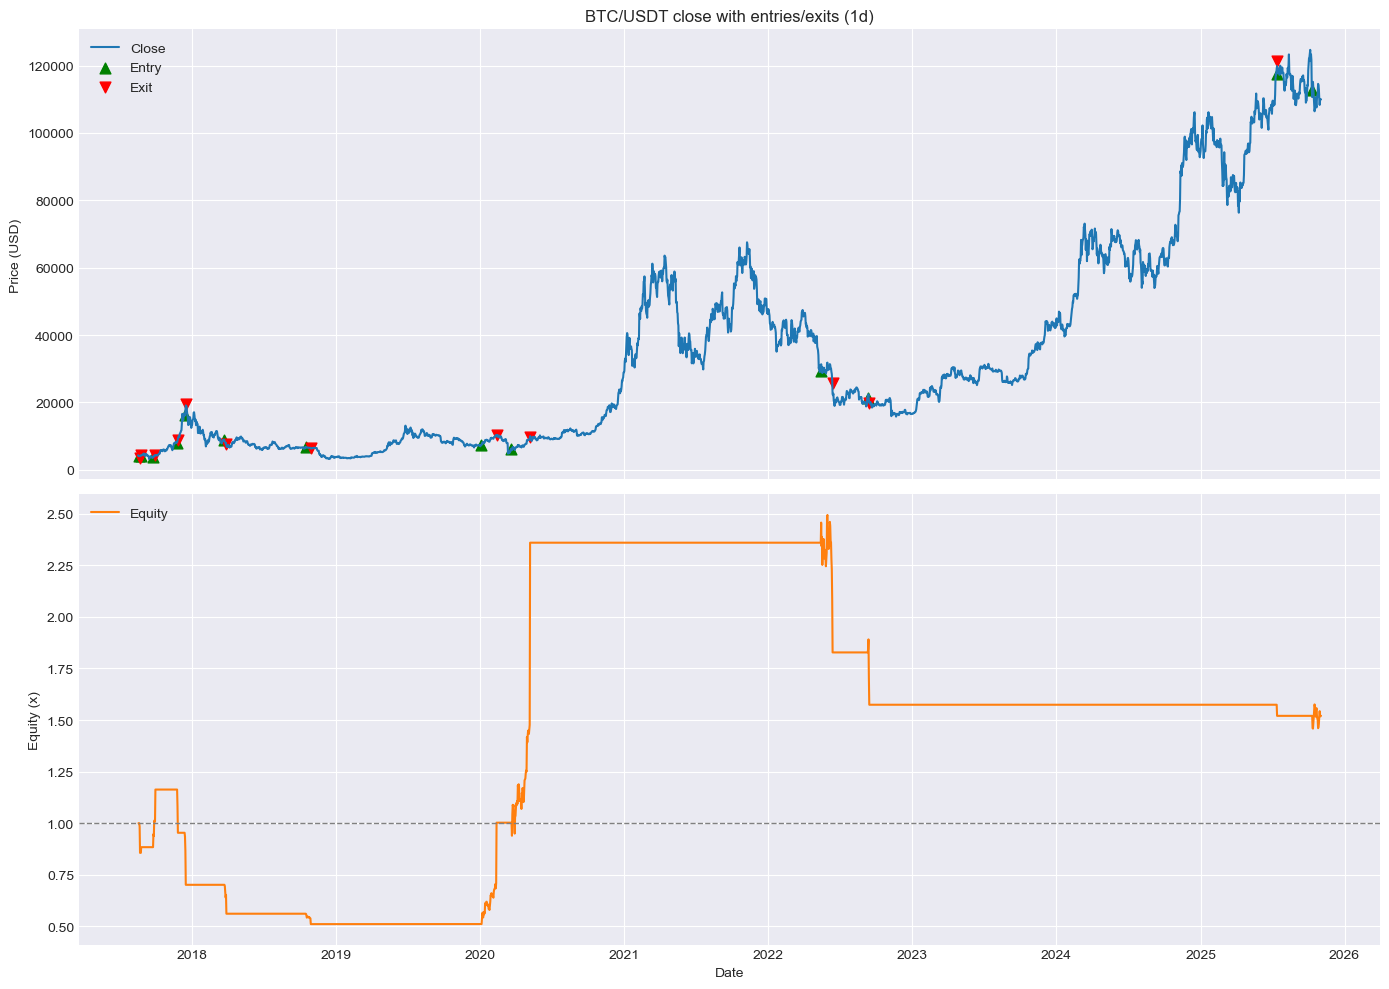

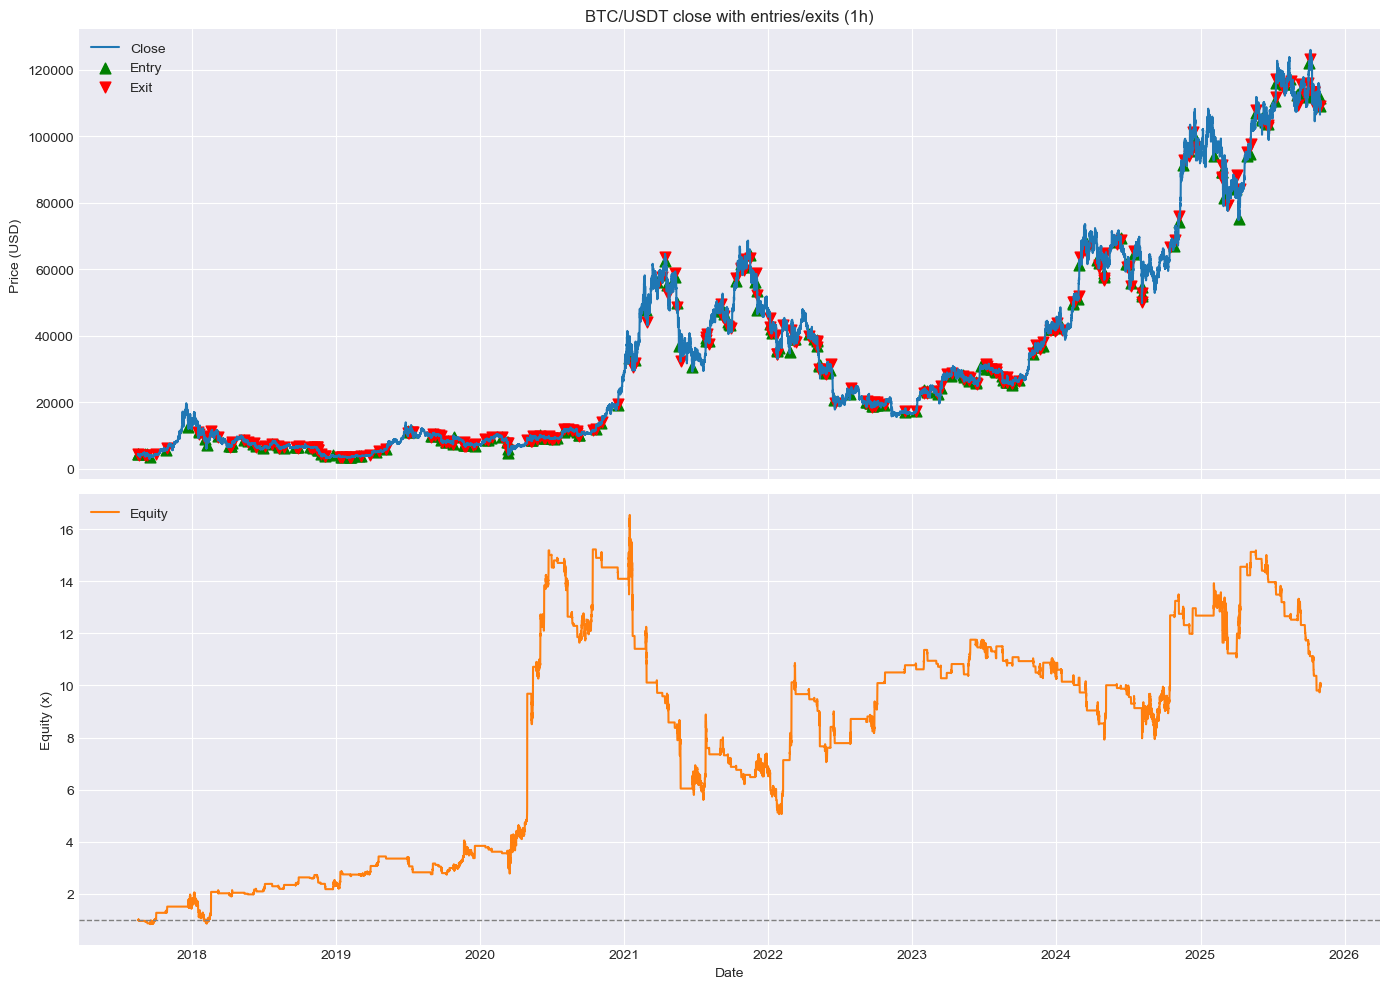

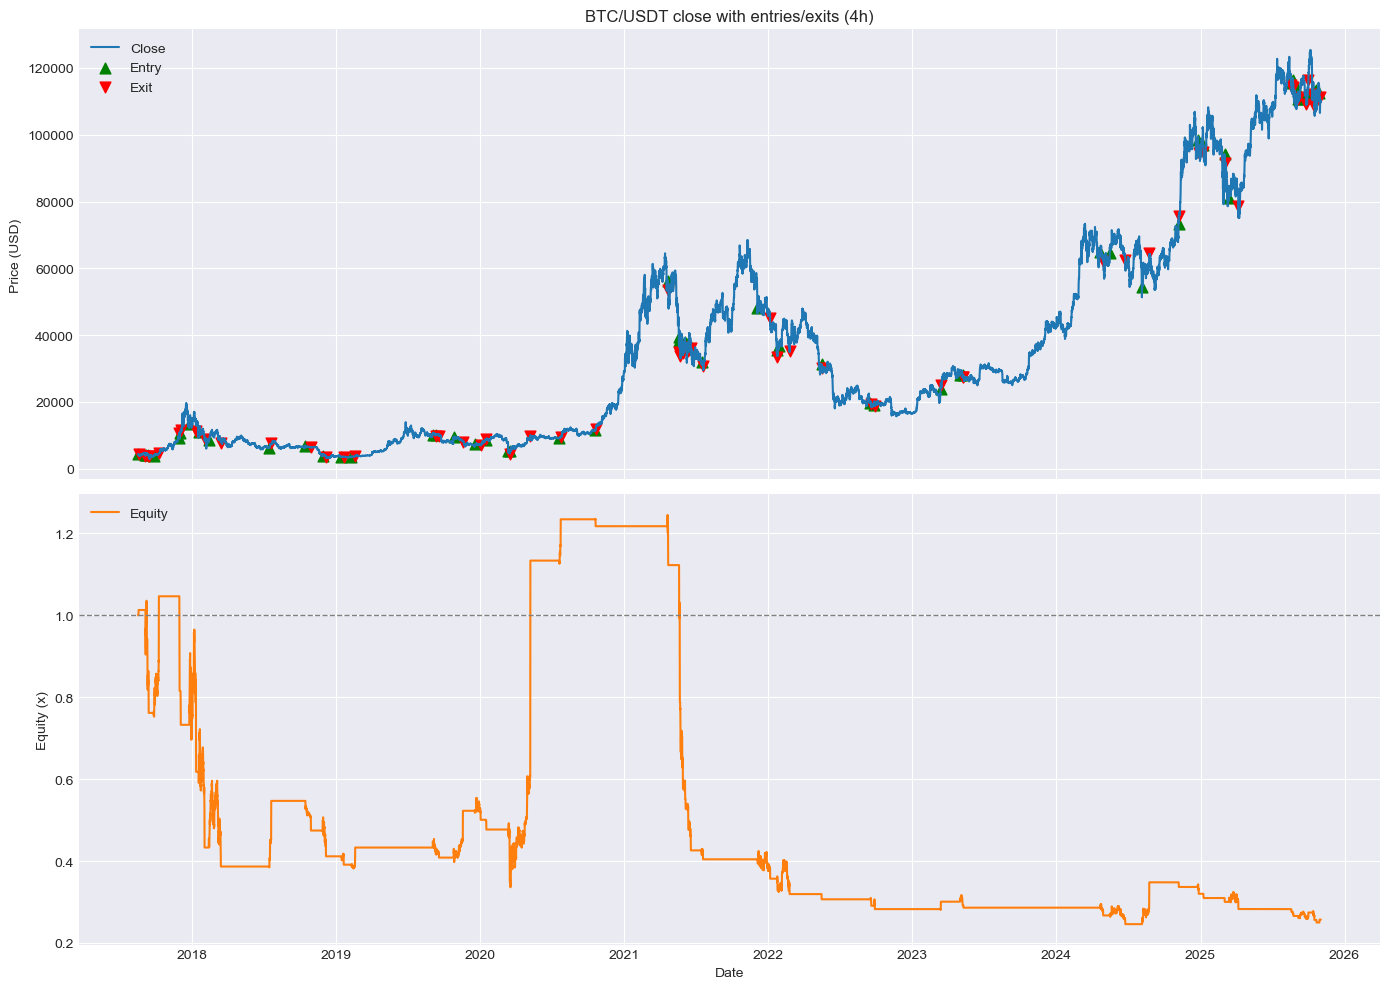

In [17]:
for tf in timeframes:
    df_tf = frames[tf]
    detail_tf = details[tf]
    fig, (ax_price, ax_eq) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    ax_price.plot(df_tf.index, df_tf['close'], label='Close', color='tab:blue')
    entries = detail_tf[detail_tf['entry_flag'] == 1]
    exits = detail_tf[detail_tf['exit_flag'] == 1]
    if not entries.empty:
        ax_price.scatter(entries.index, entries['entry_price'], marker='^', color='green', s=60, label='Entry')
    if not exits.empty:
        ax_price.scatter(exits.index, exits['exit_price'], marker='v', color='red', s=60, label='Exit')
    ax_price.set_ylabel('Price (USD)')
    ax_price.set_title(f'BTC/USDT close with entries/exits ({tf})')
    ax_price.legend(loc='upper left')
    ax_eq.plot(detail_tf.index, detail_tf['equity'], color='tab:orange', label='Equity')
    ax_eq.axhline(1.0, color='gray', linewidth=1, linestyle='--')
    ax_eq.set_ylabel('Equity (x)')
    ax_eq.set_xlabel('Date')
    ax_eq.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


In [18]:
pd.concat({
    tf: details[tf][['pos', 'entry_flag', 'exit_flag', 'entry_price', 'exit_price', 'equity']].tail()
    for tf in timeframes
}, axis=0)


pos  entry_flag  exit_flag  entry_price  exit_price  \
   open_time                                                                  
1d 2025-10-29 00:00:00   -1           0          0          NaN         NaN   
   2025-10-30 00:00:00   -1           0          0          NaN         NaN   
   2025-10-31 00:00:00   -1           0          0          NaN         NaN   
   2025-11-01 00:00:00   -1           0          0          NaN         NaN   
   2025-11-02 00:00:00   -1           0          0          NaN         NaN   
1h 2025-11-01 20:00:00    1           0          0          NaN         NaN   
   2025-11-01 21:00:00    1           0          0          NaN         NaN   
   2025-11-01 22:00:00    1           0          0          NaN         NaN   
   2025-11-01 23:00:00    1           0          0          NaN         NaN   
   2025-11-02 00:00:00    1           0          0          NaN         NaN   
4h 2025-11-01 08:00:00    0           0          0          NaN         NaN   
   2025-11-01 12:00:00    0           0          0          NaN         NaN   
   2025-11-01 16:00:00    0           0          0          NaN         NaN   
   2025-11-01 20:00:00    0           0          0          NaN         NaN   
   2025-11-02 00:00:00    0           0          0          NaN         NaN   

                           equity  
   open_time                       
1d 2025-10-29 00:00:00   1.519611  
   2025-10-30 00:00:00   1.543070  
   2025-10-31 00:00:00   1.524763  
   2025-11-01 00:00:00   1.517945  
   2025-11-02 00:00:00   1.519800  
1h 2025-11-01 20:00:00  10.065482  
   2025-11-01 21:00:00  10.015946  
   2025-11-01 22:00:00  10.036908  
   2025-11-01 23:00:00  10.037393  
   2025-11-02 00:00:00  10.023800  
4h 2025-11-01 08:00:00   0.257055  
   2025-11-01 12:00:00   0.257055  
   2025-11-01 16:00:00   0.257055  
   2025-11-01 20:00:00   0.257055  
   2025-11-02 00:00:00   0.257055